**Credit Card Fraud Detection using Scikit-Learn and Snap ML**


In [3]:
# Install required libraries
!pip install snapml

In [4]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import gc

In [6]:
# Load dataset
data_path = 'creditcard.csv'
raw_data = pd.read_csv(data_path)
print(f"Dataset contains {len(raw_data)} observations and {len(raw_data.columns)} variables.")


Dataset contains 284807 observations and 31 variables.


In [7]:
# Display first few rows
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Data augmentation
n_replicas = 10
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)
print(f"Inflated dataset contains {len(big_raw_data)} observations.")


Inflated dataset contains 2848070 observations.


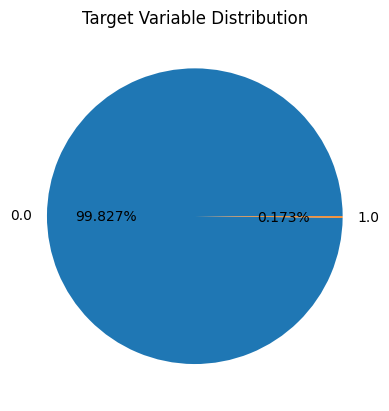

In [9]:
# Visualize class distribution
labels = big_raw_data.Class.unique()
sizes = big_raw_data.Class.value_counts().values
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Distribution')
plt.show()

In [11]:
# Data preprocessing
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values
X = data_matrix[:, 1:30]
y = data_matrix[:, 30]
X = normalize(X, norm="l1")

In [12]:
X = data_matrix[:, 1:30]
y = data_matrix[:, 30]
X = normalize(X, norm="l1")

In [13]:
# Memory cleanup
del raw_data, big_raw_data
gc.collect()

1959

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (1993649, 29), Testing set: (854421, 29)


In [15]:
# Compute sample weights
w_train = compute_sample_weight('balanced', y_train)


In [16]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print(f"[Scikit-Learn] Training time: {sklearn_time:.5f} seconds")


[Scikit-Learn] Training time: 57.93491 seconds


In [17]:
# Snap ML Decision Tree
from snapml import DecisionTreeClassifier
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print(f"[Snap ML] Training time: {snapml_time:.5f} seconds")


[Snap ML] Training time: 8.42871 seconds


In [18]:
# Compare performance
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]
print(f"[Scikit-Learn] ROC-AUC: {roc_auc_score(y_test, sklearn_pred):.3f}")
print(f"[Snap ML] ROC-AUC: {roc_auc_score(y_test, snapml_pred):.3f}")


[Scikit-Learn] ROC-AUC: 0.966
[Snap ML] ROC-AUC: 0.966


In [19]:
# Support Vector Machine (SVM)
from sklearn.svm import LinearSVC
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print(f"[Scikit-Learn] SVM Training time: {sklearn_time:.2f} seconds")

from snapml import SupportVectorMachine
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
t0 = time.time()
snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print(f"[Snap ML] SVM Training time: {snapml_time:.2f} seconds")


[Scikit-Learn] SVM Training time: 100.75 seconds
[Snap ML] SVM Training time: 16.63 seconds


In [20]:
# Compare SVM performance
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred = snapml_svm.decision_function(X_test)
print(f"[Scikit-Learn] SVM ROC-AUC: {roc_auc_score(y_test, sklearn_pred):.3f}")
print(f"[Snap ML] SVM ROC-AUC: {roc_auc_score(y_test, snapml_pred):.3f}")

[Scikit-Learn] SVM ROC-AUC: 0.984
[Snap ML] SVM ROC-AUC: 0.985


***Credit Card Fraud Detection using Scikit-Learn and Snap ML FInal Analysis***


In [21]:
!pip install snapml

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, roc_curve
import time
import gc

In [25]:
data_path = 'creditcard.csv'
raw_data = pd.read_csv(data_path)
print(f"Dataset contains {len(raw_data)} observations and {len(raw_data.columns)} variables.")

Dataset contains 284807 observations and 31 variables.


In [27]:
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [28]:
n_replicas = 10
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)
print(f"Inflated dataset contains {len(big_raw_data)} observations.")

Inflated dataset contains 2848070 observations.


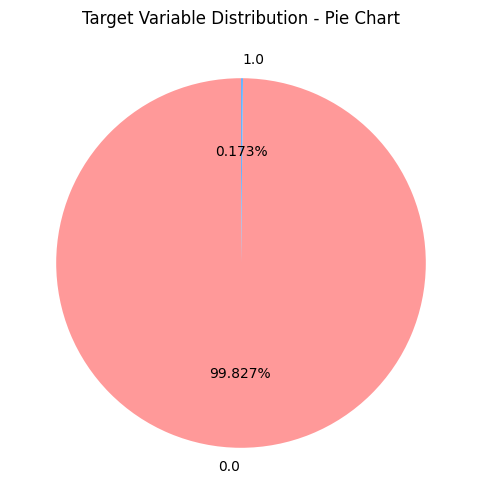

In [29]:
labels = big_raw_data.Class.unique()
sizes = big_raw_data.Class.value_counts().values

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.3f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
ax.set_title('Target Variable Distribution - Pie Chart')
plt.show()

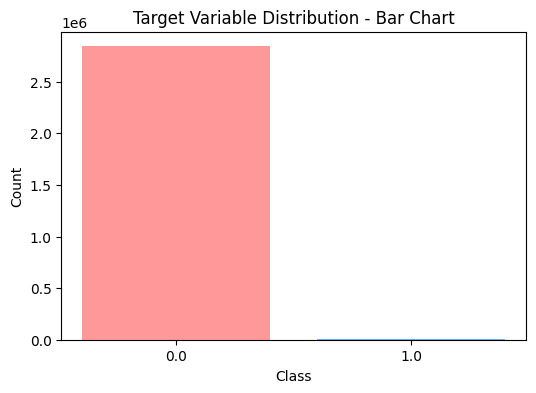

In [30]:
class_counts = big_raw_data['Class'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['#ff9999', '#66b3ff'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Target Variable Distribution - Bar Chart')
plt.show()

In [31]:
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values
X = data_matrix[:, 1:30]
y = data_matrix[:, 30]
X = normalize(X, norm="l1")
del raw_data, big_raw_data
gc.collect()

4222

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
w_train = compute_sample_weight('balanced', y_train)

Training set: (1993649, 29), Testing set: (854421, 29)


In [33]:
from sklearn.tree import DecisionTreeClassifier
from snapml import DecisionTreeClassifier as SnapMLDecisionTree

sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_dt_time = time.time() - t0
print(f"[Scikit-Learn Decision Tree] Training time: {sklearn_dt_time:.5f} seconds")

[Scikit-Learn Decision Tree] Training time: 51.55304 seconds


In [34]:
snapml_dt = SnapMLDecisionTree(max_depth=4, random_state=45, n_jobs=4)
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_dt_time = time.time() - t0
print(f"[Snap ML Decision Tree] Training time: {snapml_dt_time:.5f} seconds")

[Snap ML Decision Tree] Training time: 8.25520 seconds


In [42]:
sklearn_dt_pred = sklearn_dt.predict_proba(X_test)[:, 1]  # Make sure this line is executed first
snapml_dt_pred = snapml_dt.predict_proba(X_test)[:, 1]
sklearn_dt_auc = roc_auc_score(y_test, sklearn_dt_pred)
snapml_dt_auc = roc_auc_score(y_test, snapml_dt_pred)
print(f"[Scikit-Learn Decision Tree] ROC-AUC: {sklearn_dt_auc:.3f}")
print(f"[Snap ML Decision Tree] ROC-AUC: {snapml_dt_auc:.3f}")

[Scikit-Learn Decision Tree] ROC-AUC: 0.966
[Snap ML Decision Tree] ROC-AUC: 0.966


In [37]:
from sklearn.svm import LinearSVC
from snapml import SupportVectorMachine

sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_svm_time = time.time() - t0
print(f"[Scikit-Learn SVM] Training time: {sklearn_svm_time:.2f} seconds")

[Scikit-Learn SVM] Training time: 101.79 seconds


In [38]:
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
t0 = time.time()
snapml_svm.fit(X_train, y_train)
snapml_svm_time = time.time() - t0
print(f"[Snap ML SVM] Training time: {snapml_svm_time:.2f} seconds")

[Snap ML SVM] Training time: 16.44 seconds


In [39]:
sklearn_svm_pred = sklearn_svm.decision_function(X_test)
snapml_svm_pred = snapml_svm.decision_function(X_test)
sklearn_svm_auc = roc_auc_score(y_test, sklearn_svm_pred)
snapml_svm_auc = roc_auc_score(y_test, snapml_svm_pred)
print(f"[Scikit-Learn SVM] ROC-AUC: {sklearn_svm_auc:.3f}")
print(f"[Snap ML SVM] ROC-AUC: {snapml_svm_auc:.3f}")

[Scikit-Learn SVM] ROC-AUC: 0.984
[Snap ML SVM] ROC-AUC: 0.985


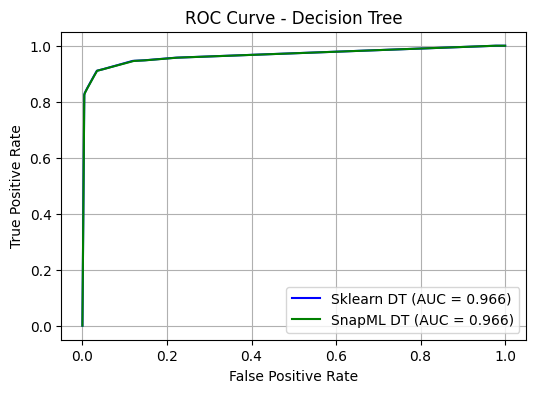

In [43]:
fpr_sklearn_dt, tpr_sklearn_dt, _ = roc_curve(y_test, sklearn_dt_pred)
fpr_snapml_dt, tpr_snapml_dt, _ = roc_curve(y_test, snapml_dt_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr_sklearn_dt, tpr_sklearn_dt, label=f"Sklearn DT (AUC = {sklearn_dt_auc:.3f})", color='blue')
plt.plot(fpr_snapml_dt, tpr_snapml_dt, label=f"SnapML DT (AUC = {snapml_dt_auc:.3f})", color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

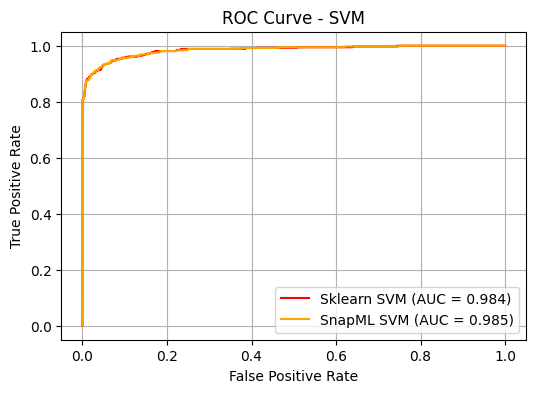

In [44]:
fpr_sklearn_svm, tpr_sklearn_svm, _ = roc_curve(y_test, sklearn_svm_pred)
fpr_snapml_svm, tpr_snapml_svm, _ = roc_curve(y_test, snapml_svm_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr_sklearn_svm, tpr_sklearn_svm, label=f"Sklearn SVM (AUC = {sklearn_svm_auc:.3f})", color='red')
plt.plot(fpr_snapml_svm, tpr_snapml_svm, label=f"SnapML SVM (AUC = {snapml_svm_auc:.3f})", color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

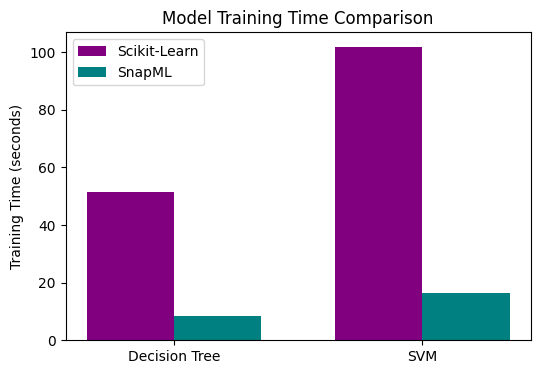

In [45]:
models = ['Decision Tree', 'SVM']
sklearn_times = [sklearn_dt_time, sklearn_svm_time]
snapml_times = [snapml_dt_time, snapml_svm_time]
x = np.arange(len(models))
width = 0.35
plt.figure(figsize=(6, 4))
plt.bar(x - width/2, sklearn_times, width, label='Scikit-Learn', color='purple')
plt.bar(x + width/2, snapml_times, width, label='SnapML', color='teal')
plt.ylabel('Training Time (seconds)')
plt.title('Model Training Time Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()

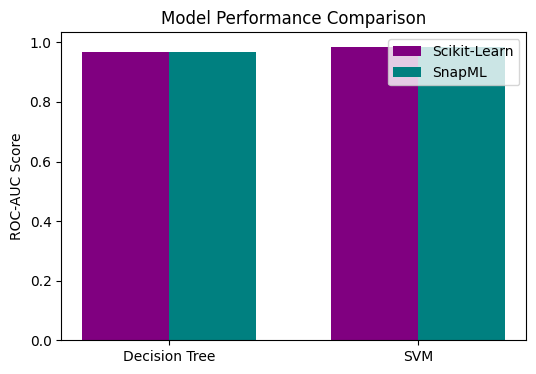

In [46]:
sklearn_auc = [sklearn_dt_auc, sklearn_svm_auc]
snapml_auc = [snapml_dt_auc, snapml_svm_auc]
plt.figure(figsize=(6, 4))
plt.bar(x - width/2, sklearn_auc, width, label='Scikit-Learn', color='purple')
plt.bar(x + width/2, snapml_auc, width, label='SnapML', color='teal')
plt.ylabel('ROC-AUC Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()